In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import binned_statistic

torch.set_printoptions(sci_mode = False)
np.set_printoptions(suppress = True)

/home/kim/eccv/.conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Quantitative characterization of surface topography
using spectral analysis

https://arxiv.org/pdf/1607.03040

PSD from FFT

In [19]:
xyvxvys = torch.load("data/test_byrd_grid_xyvxvys.pt")

In [ ]:
# reshape to grid
vx_grid = xyvxvys[2].reshape(400, 400)

# Issue: we have NaNs in the grid
torch.isnan(vx_grid).sum()

# replace these values
vx_grid_nonzero = torch.nan_to_num(vx_grid, nan = 0.0)

In [49]:
s_grid = xyvxvys[-1].reshape(400, 400)
torch.isnan(s_grid).sum()

tensor(0)

In [95]:
data = s_grid
# data = vx_grid_nonzero

# Toy problem

In [82]:
import torch

# Example: Create a simple 2D tensor
data = torch.zeros((8, 8))
data[6:8, 6:8] = 1  # Small block in the center

# Compute 2D FFT
F = torch.fft.fft2(data)

# Compute magnitude (power spectrum)
F_magnitude = torch.abs(F)

print(F_magnitude)

tensor([[4.0000, 3.6955, 2.8284, 1.5307, 0.0000, 1.5307, 2.8284, 3.6955],
        [3.6955, 3.4142, 2.6131, 1.4142, 0.0000, 1.4142, 2.6131, 3.4142],
        [2.8284, 2.6131, 2.0000, 1.0824, 0.0000, 1.0824, 2.0000, 2.6131],
        [1.5307, 1.4142, 1.0824, 0.5858, 0.0000, 0.5858, 1.0824, 1.4142],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.5307, 1.4142, 1.0824, 0.5858, 0.0000, 0.5858, 1.0824, 1.4142],
        [2.8284, 2.6131, 2.0000, 1.0824, 0.0000, 1.0824, 2.0000, 2.6131],
        [3.6955, 3.4142, 2.6131, 1.4142, 0.0000, 1.4142, 2.6131, 3.4142]])


In [83]:
F_shifted = torch.fft.fftshift(F_magnitude)
print(F_shifted)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5858, 1.0824, 1.4142, 1.5307, 1.4142, 1.0824, 0.5858],
        [0.0000, 1.0824, 2.0000, 2.6131, 2.8284, 2.6131, 2.0000, 1.0824],
        [0.0000, 1.4142, 2.6131, 3.4142, 3.6955, 3.4142, 2.6131, 1.4142],
        [0.0000, 1.5307, 2.8284, 3.6955, 4.0000, 3.6955, 2.8284, 1.5307],
        [0.0000, 1.4142, 2.6131, 3.4142, 3.6955, 3.4142, 2.6131, 1.4142],
        [0.0000, 1.0824, 2.0000, 2.6131, 2.8284, 2.6131, 2.0000, 1.0824],
        [0.0000, 0.5858, 1.0824, 1.4142, 1.5307, 1.4142, 1.0824, 0.5858]])


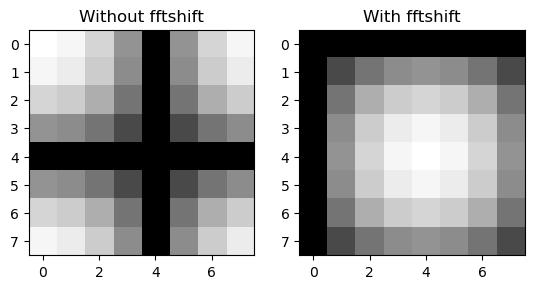

In [84]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(torch.log1p(F_magnitude).numpy(), cmap="gray")  # Without fftshift
plt.title("Without fftshift")

plt.subplot(1, 2, 2)
plt.imshow(torch.log1p(F_shifted).numpy(), cmap="gray")  # With fftshift
plt.title("With fftshift")

plt.show()

# 2D Fourier Transform

The discrete Fourier transform is separable, so fft2() here is equivalent to two one-dimensional fft() calls.

In [105]:
# 2D FFT (return complex numbers) https://pytorch.org/docs/stable/generated/torch.fft.fft2.html 
F = torch.fft.fft2(data) # Compute FFT

# Shifting swaps quadrants only
F_shifted = torch.fft.fftshift(F)  # Shift zero frequency to the center (order)

# Power spectrum is the squared magnitude of the FFT
PSD = torch.abs(F_shifted) ** 2  # Compute power spectrum
# PSD = torch.abs(F) ** 2

In [106]:
nx, ny = data.shape
dx, dy = 0.5, 0.5 # (in km)

# Frequency resolution (cycles per meter)
f_x = 1 / dx  # cycles per meter
f_y = 1 / dy  # cycles per meter

kx = torch.fft.fftfreq(nx, d = dx) * nx  # Normalized frequencies
ky = torch.fft.fftfreq(ny, d = dy) * ny
kx, ky = torch.meshgrid(kx, ky, indexing = "ij") 

In [107]:
# Compute radial distances
kr = torch.sqrt(kx**2 + ky**2).flatten()
psd_flat = PSD.flatten()

# Convert to NumPy (since PyTorch lacks a direct binned statistic function)
kr_np = kr.numpy()
psd_np = psd_flat.numpy()

# Bin the power spectrum radially

bins = np.logspace(np.log10(kr_np.min() + 1e-6), np.log10(kr_np.max()), num=50)
psd_radial, _, _ = binned_statistic(kr_np, psd_np, statistic="mean", bins=bins)

The DC component refers to the zero-frequency component of a Fourier transform. It represents the average value or constant offset of a signal or image

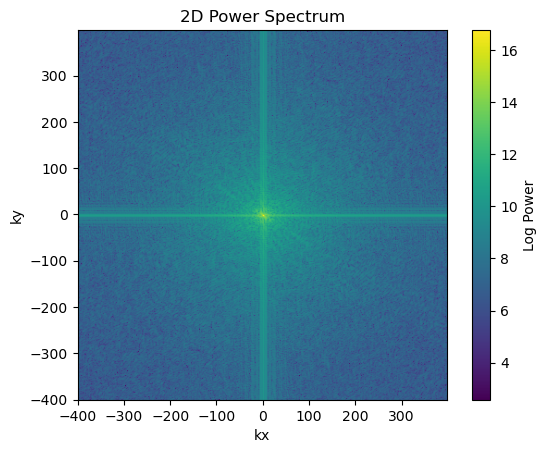

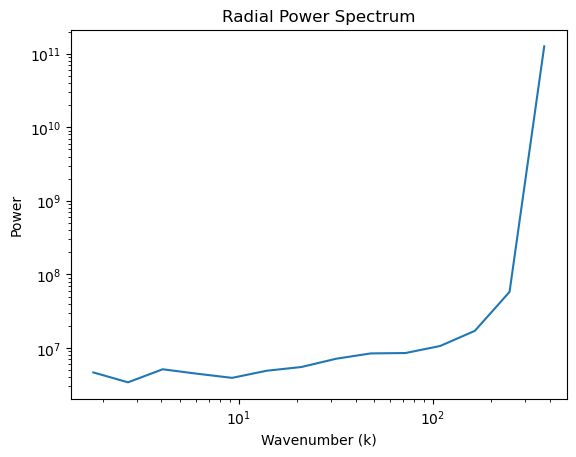

In [110]:
import matplotlib.pyplot as plt

# 2D Spectrum (log-scale for better visualization)
plt.imshow(torch.log10(PSD).numpy(), extent = [kx.min(), kx.max(), ky.min(), ky.max()])
plt.colorbar(label="Log Power")
plt.title("2D Power Spectrum")
plt.xlabel("kx")
plt.ylabel("ky")
plt.show()

# 1D Radial Power Spectrum
plt.plot(bins[:-1], psd_radial)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Wavenumber (k)")
plt.ylabel("Power")
plt.title("Radial Power Spectrum")
plt.show()